In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
interval = '4h'
btc_data = pd.read_csv(f'data/btc_{interval}_data_with_ma.csv', index_col=False)
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'])

In [42]:
# ma_candidates = [10, 20, 30, 50, 60, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
# ma_candidates = [450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560]
# ma_candidates = [1000, 1010, 1020, 1030, 1040, 1050, 1060]

In [52]:
# Function to backtest strategy and calculate cumulative profit
def backtest_and_calculate_profit(df, ma):
    df['Position'] = np.where(df['close'] > df[f'MA_{ma}'], 1, 0)  # 1 for buy, 0 for sell
    df['Signal'] = df['Position'].diff()  # Buy signal when diff > 0, sell signal when diff < 0

    # Initial values
    initial_cash = 10000  # Starting with $10,000
    btc_holding = 0
    cash = initial_cash
    purchase_price = 0
    stop_loss = 0 # No stop loss    
    
    # stop_loss = 0.995 # 0.5% loss
    # stop_loss = 0.99 # 1% loss
    # stop_loss = 0.98 # 2% loss
    # stop_loss = 0.97 # 3% loss

    for i in range(0, len(df)):
        price = df['close'].iloc[i]

        # Stop loss check: Sell if the price drops more than 1% below the purchase price
        if btc_holding > 0 and price < purchase_price * stop_loss:
            sell_price = price #* (1 - 0.01 / 100) # sell price 0.01% lower 
            cash = btc_holding * sell_price  # Sell all BTC and hold cash
            btc_holding = 0  # No BTC left after selling
            current_time = df['timestamp'].iloc[i]
            print(f"{current_time}: Stop loss triggered! Sold BTC at {sell_price:,.2f}, now holding {cash:,.2f} USDT")

        else:
            # Buy signal
            if df['Signal'].iloc[i] == 1:  # Crosses above MA
                if price < df['MA_560'].iloc[i]: # 장기 이평 아래면 안 산다. -> 하락추세로 판단
                    continue
                if cash > 0:
                    purchase_price = price #* (1 + 0.01 / 100) # buy price 0.01% higher
                    btc_holding = cash / purchase_price  # Buy BTC with all available cash
                    cash = 0  # No cash left after buying
                    current_time = df['timestamp'].iloc[i]
                    print(f"{current_time}: Bought BTC at {purchase_price:,.2f}, holding {btc_holding:.4f} BTC")

            # Sell signal
            elif df['Signal'].iloc[i] == -1:  # Crosses below MA
                if btc_holding > 0:
                    sell_price = price #* (1 - 0.01 / 100) # sell price 0.01% lower
                    cash = btc_holding * sell_price  # Sell all BTC and hold cash
                    btc_holding = 0  # No BTC left after selling
                    current_time = df['timestamp'].iloc[i]
                    print(f"{current_time}: Sold BTC at {sell_price:,.2f}, now holding {cash:,.2f} USDT\n")
        
        # Calculate current portfolio value (cash + value of BTC)
        portfolio_value = cash + (btc_holding * price)
        # Update the portfolio value for each iteration
        df.loc[i, 'portfolio_value'] = portfolio_value

    # Drop 'Signal' and 'Position' columns
    df = df.drop(columns=['Signal', 'Position'])

    # df['portfolio_value'] = portfolio_value
    # print(f"Final value for MA {ma}: {portfolio_value:,.2f} USDT")
    return df

## Filter 2018, 2022

In [61]:
# Filter btc_data for the year 2018 and 2022
btc_data_2018 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2018])]
btc_data_2018 = btc_data_2018.drop(btc_data_2018[~pd.to_datetime(btc_data_2018['timestamp']).dt.year.isin([2018])].index)
btc_data_2018 = btc_data_2018.reset_index(drop=True)

btc_data_2022 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2022])]
btc_data_2022 = btc_data_2022.drop(btc_data_2022[~pd.to_datetime(btc_data_2022['timestamp']).dt.year.isin([2022])].index)
btc_data_2022 = btc_data_2022.reset_index(drop=True)

In [62]:
btc_data_2018.head()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_470,MA_480,MA_490,MA_500,MA_510,MA_520,MA_530,MA_540,MA_550,MA_560
0,2018-01-01 00:00:00,13715.65,13715.65,13400.01,13529.01,443.356199,13730.774,13289.7985,13150.621333,13128.1344,...,15553.255128,15575.098771,15597.938571,15611.81868,15607.546216,15586.015962,15546.881340,15523.114556,15513.817345,15512.317161
1,2018-01-01 01:00:00,13528.99,13595.89,13155.38,13203.06,383.697006,13729.812,13317.4515,13156.056667,13104.6176,...,15546.027596,15567.280146,15591.496245,15606.04676,15603.109706,15585.406462,15544.139811,15519.871481,15509.636436,15509.340500
2,2018-01-01 02:00:00,13203.00,13418.43,13200.00,13330.18,429.064572,13679.230,13356.8395,13174.528333,13085.4598,...,15539.842043,15560.468021,15585.363959,15599.60714,15599.413961,15584.887481,15542.599925,15517.332889,15506.003345,15506.126536
3,2018-01-01 03:00:00,13330.26,13611.27,13290.00,13410.03,420.087030,13643.934,13387.4680,13196.599000,13078.3702,...,15532.783383,15554.472250,15579.527286,15593.56520,15597.679706,15584.598019,15542.618849,15515.489463,15502.918836,15502.930232
4,2018-01-01 04:00:00,13434.98,13623.29,13322.15,13601.01,340.807329,13630.325,13439.9180,13227.385333,13083.6670,...,15526.851489,15548.932604,15573.610980,15588.15722,15596.152275,15584.369173,15543.265906,15514.774704,15500.057909,15500.401018


## Test {ma} MA

In [53]:
ma = 260
profit_df = backtest_and_calculate_profit(btc_data, ma)
portfolio_value = profit_df['portfolio_value'].iloc[-1]
print(f"Final value interval {interval} for {ma} MA: {portfolio_value:,.2f} USDT")

2017-09-29 08:00:00: Bought BTC at 4,220.01, holding 2.3697 BTC
2017-10-05 00:00:00: Sold BTC at 4,143.04, now holding 9,817.61 USDT

2017-10-05 04:00:00: Bought BTC at 4,154.10, holding 2.3634 BTC
2017-12-30 12:00:00: Sold BTC at 12,313.99, now holding 29,102.31 USDT

2017-12-30 16:00:00: Bought BTC at 13,040.00, holding 2.2318 BTC
2017-12-30 20:00:00: Sold BTC at 12,440.01, now holding 27,763.27 USDT

2017-12-31 00:00:00: Bought BTC at 12,962.06, holding 2.1419 BTC
2017-12-31 04:00:00: Sold BTC at 12,797.46, now holding 27,410.72 USDT

2017-12-31 08:00:00: Bought BTC at 12,989.94, holding 2.1101 BTC
2018-01-09 20:00:00: Sold BTC at 14,400.00, now holding 30,386.15 USDT

2018-01-10 20:00:00: Bought BTC at 14,907.09, holding 2.0384 BTC
2018-01-11 00:00:00: Sold BTC at 12,920.00, now holding 26,335.73 USDT

2018-08-28 12:00:00: Bought BTC at 7,049.79, holding 3.7357 BTC
2018-08-29 00:00:00: Sold BTC at 7,045.00, now holding 26,317.84 USDT

2018-08-29 04:00:00: Bought BTC at 7,060.92, ho

## Test all ma candidates

In [37]:
portfolio_value_by_ma = {}
for ma in ma_candidates:
    profit = backtest_and_calculate_profit(btc_data, ma)
    portfolio_value_by_ma[ma] = profit['portfolio_value'].iloc[-1]

2017-09-28 01:00:00: Bought BTC at 4,187.99, holding 2.3878 BTC
2017-09-28 10:00:00: Stop loss triggered! Sold BTC at 4,148.00, now holding 9,904.51 USDT
2017-09-29 08:00:00: Bought BTC at 4,129.98, holding 2.3982 BTC
2017-09-29 09:00:00: Stop loss triggered! Sold BTC at 4,063.01, now holding 9,743.91 USDT
2017-09-29 10:00:00: Bought BTC at 4,145.30, holding 2.3506 BTC
2017-09-29 22:00:00: Stop loss triggered! Sold BTC at 4,120.01, now holding 9,684.46 USDT
2017-10-05 05:00:00: Bought BTC at 4,150.00, holding 2.3336 BTC
2017-10-05 06:00:00: Sold BTC at 4,135.02, now holding 9,649.50 USDT

2017-10-05 07:00:00: Bought BTC at 4,154.10, holding 2.3229 BTC
2017-10-05 08:00:00: Stop loss triggered! Sold BTC at 4,115.00, now holding 9,558.68 USDT
2017-10-05 09:00:00: Bought BTC at 4,199.12, holding 2.2764 BTC
2017-11-12 05:00:00: Sold BTC at 5,739.97, now holding 13,066.19 USDT

2017-11-12 07:00:00: Bought BTC at 6,060.00, holding 2.1561 BTC
2017-11-12 19:00:00: Stop loss triggered! Sold BTC 

In [38]:
print (f"interval: {interval}")

for ma, value in portfolio_value_by_ma.items():
    print(f"Final value for MA {ma}: {value:,.2f} USDT") 

# Find the MA with the highest portfolio value
best_ma = max(portfolio_value_by_ma, key=portfolio_value_by_ma.get)
best_value = portfolio_value_by_ma[best_ma]

print(f"The best performing for {interval} is {best_ma} MA with a final portfolio value of {best_value:,.2f} USDT")


interval: 1h
Final value for MA 1000: 206,133.83 USDT
Final value for MA 1010: 265,549.82 USDT
Final value for MA 1020: 260,835.96 USDT
Final value for MA 1030: 221,726.98 USDT
Final value for MA 1040: 218,318.35 USDT
Final value for MA 1050: 249,704.71 USDT
Final value for MA 1060: 253,212.47 USDT
The best performing for 1h is 1010 MA with a final portfolio value of 265,549.82 USDT


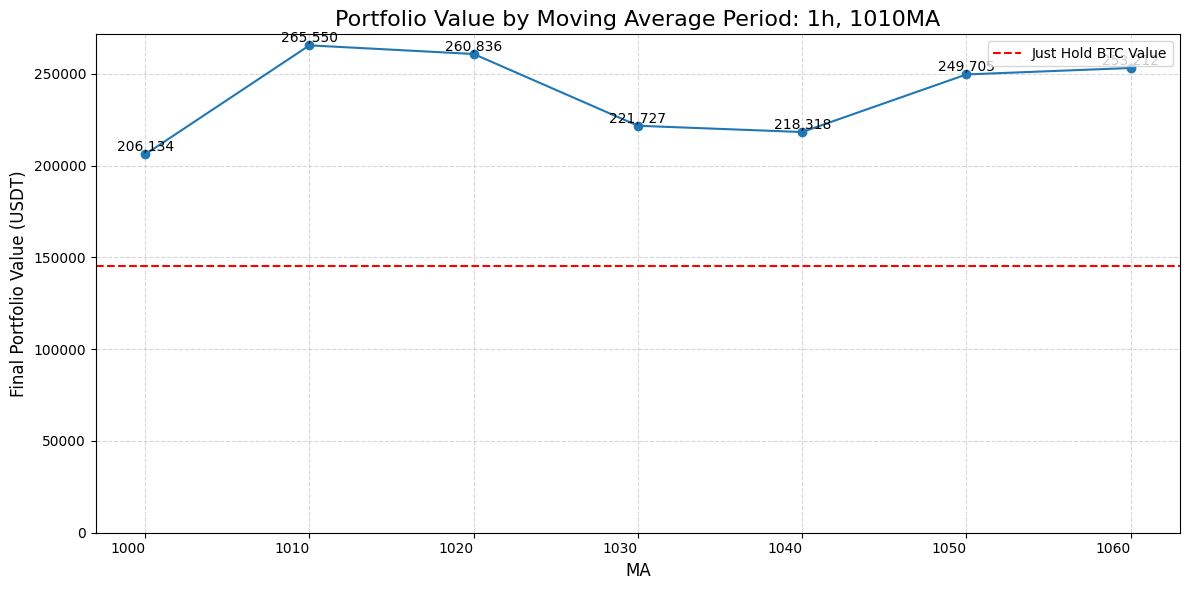

In [39]:
# Sort the dictionary by MA values
sorted_portfolio_value = dict(sorted(portfolio_value_by_ma.items()))

# Extract MA values and corresponding portfolio values
ma_values = list(sorted_portfolio_value.keys())
portfolio_values = list(sorted_portfolio_value.values())

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(ma_values, portfolio_values, marker='o')

# Customize the plot
plt.title(f'Portfolio Value by Moving Average Period: {interval}, {best_ma}MA', fontsize=16)
plt.xlabel('MA', fontsize=12)
plt.ylabel('Final Portfolio Value (USDT)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Add value labels on top of each point
for i, value in enumerate(portfolio_values):
    plt.text(ma_values[i], value, f'{value:,.0f}', ha='center', va='bottom')

# Add x-axis labels for each MA value
plt.xticks(ma_values, [f'{ma}' for ma in ma_values], rotation=0, ha='right')

# Adjust the bottom margin to accommodate the labels
plt.subplots_adjust(bottom=0.2)

# Add a horizontal line at 145,580.15
plt.axhline(y=145580.15, color='red', linestyle='--', label='Just Hold BTC Value')
plt.legend()

# Adjust y-axis to start from 0
plt.ylim(bottom=0)

# Show the plot
plt.tight_layout()
plt.show()


## Just holding BTC


In [28]:
# Function to calculate final value of holding BTC
def calculate_holding_value(df):
    initial_cash = 10000  # Start with $10,000 in cash

    # Buy BTC at the first available price
    initial_price = df['close'].iloc[0]
    btc_holding = initial_cash / initial_price  # Buy BTC with all available cash

    # Sell BTC at the last available price
    final_price = df['close'].iloc[-1]
    final_value = btc_holding * final_price  # Calculate the value of the BTC holding

    print(f"Initial BTC price: {initial_price:.2f} USDT")
    print(f"Final BTC price: {final_price:.2f} USDT")
    print(f"Final value of holding BTC: {final_value:,.2f} USDT")
    
    return final_value

In [29]:

# Example usage
# Assuming 'df' is a DataFrame with your historical price data (e.g., 1-hour BTC/USDT prices)
final_value = calculate_holding_value(btc_data)

Initial BTC price: 4349.99 USDT
Final BTC price: 65502.41 USDT
Final value of holding BTC: 150,580.60 USDT


## Portfolio cumulative profit

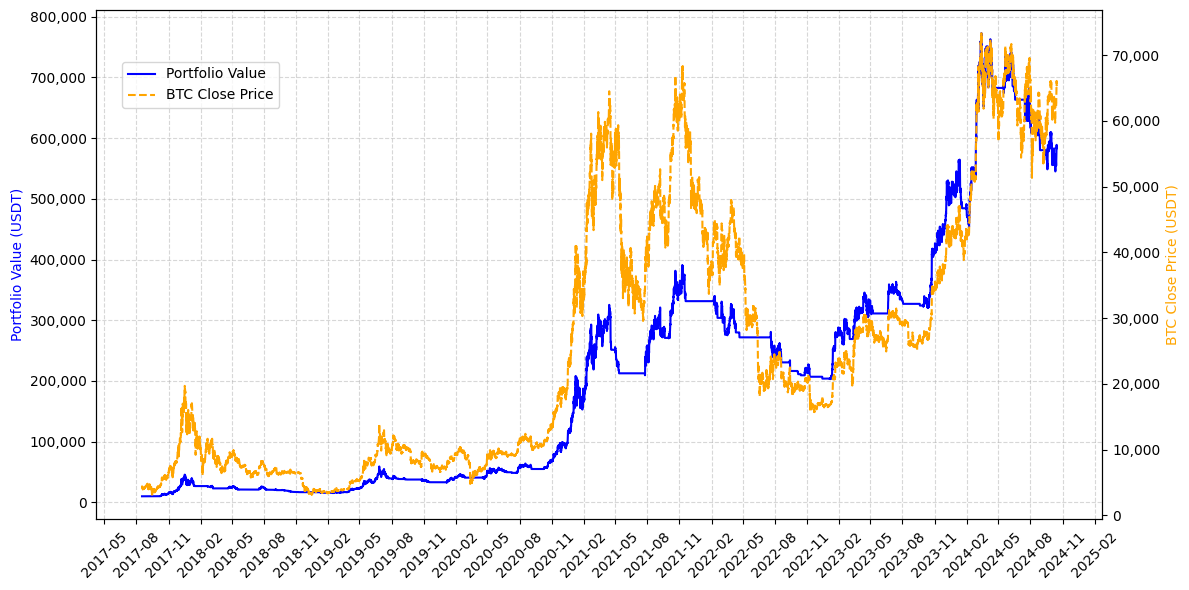

In [30]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime

# Create a new figure with a specific size
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the portfolio value over time on the left y-axis
ax1.plot(btc_data['timestamp'], btc_data['portfolio_value'], label='Portfolio Value', color='blue')

# Set x-axis ticks to show every 3 months
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Tick every 3 months

# Format the x-axis to show Year-Month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate the x-ticks for readability
plt.xticks(rotation=45)

# Set the y-axis label for portfolio value
ax1.set_ylabel('Portfolio Value (USDT)', color='blue')

# Format y-axis tick labels with commas on the left axis
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas

# Enable grid for left axis
ax1.grid(True, linestyle='--', alpha=0.5)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the BTC close price on the right y-axis
ax2.plot(btc_data['timestamp'], btc_data['close'], label='BTC Close Price', color='orange', linestyle='--')

# Set the y-axis label for BTC close price
ax2.set_ylabel('BTC Close Price (USDT)', color='orange')

# Optionally, format the y-axis on the right if needed (e.g., formatting for currency)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas

# Add a legend for both plots
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Adjust layout to prevent cutting off labels
fig.tight_layout()

# Show the plot
plt.show()

In [31]:
# Filter btc_data for the year 2018 and 2022
btc_data_2018 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2017, 2018])]
btc_data_2018 = btc_data_2018.drop(btc_data_2018[~pd.to_datetime(btc_data_2018['timestamp']).dt.year.isin([2017, 2018])].index)
btc_data_2018 = btc_data_2018.reset_index(drop=True)

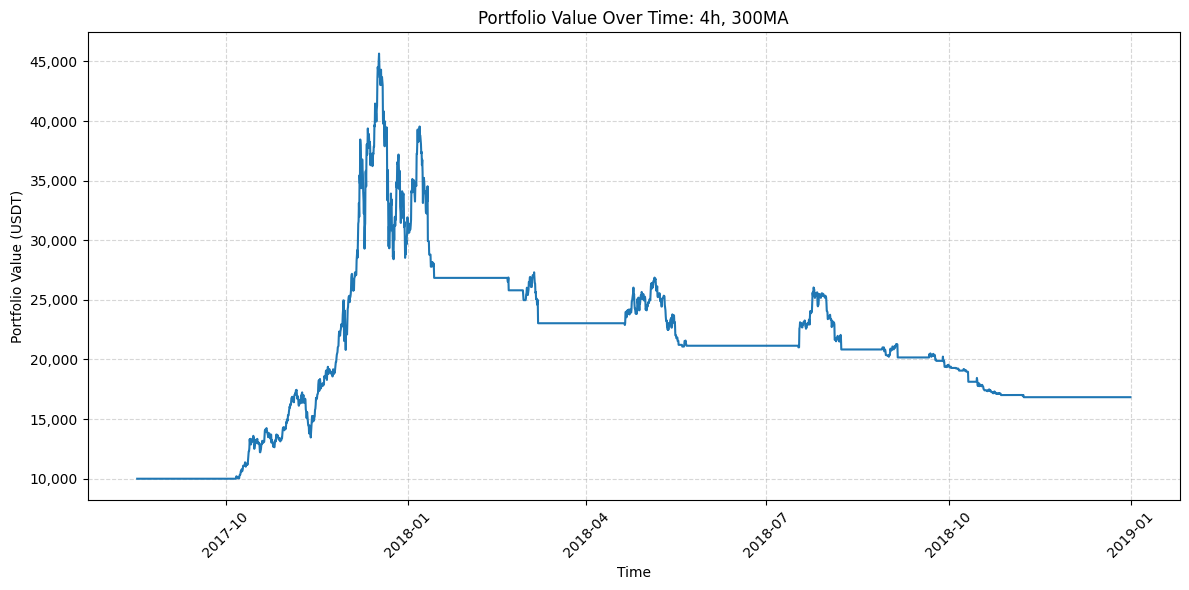

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime

# Create a new figure with a specific size
plt.figure(figsize=(12, 6))

# Plot the portfolio value over time
plt.plot(btc_data_2018['timestamp'], btc_data_2018['portfolio_value'], label='Portfolio Value')
plt.gca().autoscale()

# Set x-axis limits to show only 2017
# start_date = datetime(2017, 1, 1)
# end_date = datetime(2017, 12, 31)
# plt.xlim(start_date, end_date)

# Set x-axis ticks to show every 3 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Tick every 3 months

# Format the x-axis to show Year-Month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate the x-ticks for readability
plt.xticks(rotation=45)

# Set y-axis limits
# plt.ylim(-100000, 1300000)

# Set y-axis ticks to every 100,000 units
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100000))  # Tick every 100k

# Format y-axis tick labels with commas
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas
# Set labels and title
plt.xlabel('Time')
plt.ylabel('Portfolio Value (USDT)')
plt.title(f'Portfolio Value Over Time: {interval}, {ma}MA')

# Enable grid with a dashed line style
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()